# Using WHO Europe API to compare a few different countries health stats

Notebook 2: Preparation and analysis of data

In [59]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
%matplotlib inline

Declaring important data:

In [60]:
# the countries that we would like to study
country_names = ["Ireland", "France", "Czechia", "Poland"]
# ID codes for these countries specified by WHO database
country_ids = {"Ireland":"IRL", "France":"FRA", "Czechia":"CZE", "Poland":"POL"}
# colours that we will use in various plots
country_colours = {"Ireland":"green", "France":"navy", "Czechia":"orange", "Poland":"red"}
# what each of the codes in the file names represent
info_codes = {"HFA_1":"Population", "HFA_70":"LifeExpectancy", "HFA_566":"HealthExpenditure", "HFA_570":"HealthExpenditurePerCapita",
              "HFA_476":"BedsPer100,000", "HFA_16":"BirthsPer1000", "HFA_22":"DeathsPer1000"}
# years data recorded for
years = []
years.extend(range(1970, 2021))

Directories for data storage

In [61]:
# directory for raw data storage
dir_raw = Path("raw")
# directory for storing clean pre-processed data
dir_data = Path("data")
# make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)

## Data Preprocessing

Making the data useable

Find all of the stored json files and separate them by country

In [62]:
# creating a dictionary directory for each of the codes
key_files = {}
for code in info_codes.keys():
    key_files[code] = []
    
for fpath in dir_raw.iterdir():
    if fpath.suffix == ".json":
        # parse the filename
        parts = fpath.stem.split("-")
        # get a file fro each of the codes recorded
        if parts[0] in info_codes.keys():
            key_files[parts[0]].append(fpath)
    print("%s: Found %d raw data files" % (parts[0], len(key_files[parts[0]])))

HFA_1: Found 1 raw data files
HFA_16: Found 1 raw data files
HFA_22: Found 1 raw data files
HFA_476: Found 1 raw data files
HFA_566: Found 1 raw data files
HFA_570: Found 1 raw data files
HFA_70: Found 1 raw data files


## Data Parsing and Merging



Function to collect the raw data from the files and change it into a useable format one country at a time

In [63]:
def parse_raw_data(country_name, fpaths):
    rows = []
    # directory of a country and all the years to be studied
    for year in years :
        row = {"Country":country_name}
        row["Year"] = year
        rows.append(row)
            
    # for each file, open it and find the relevant data, add it to the dictionary
    for fpath in fpaths :
        fin = open(fpath[0], "r")
        jdata = fin.read()
        data = json.loads(jdata)
            
        for item in data["data"] :
            # make sure year is not out of range of studied data
            year_curr = int(item["dimensions"]["YEAR"])
            if item["dimensions"]["COUNTRY"] == country_ids[country_name] and year_curr < 2021 and year_curr > 1969:
                rows[year_curr-1970][info_codes[data["code"]]] = item["value"]["numeric"]
        
        fin.close()
        
    # return back the DataFrame
    return pd.DataFrame(rows).set_index("Year")

Merges the data sets for each file for each country into one data frame per country

In [64]:
def parse_merge_raw_data(country_name, fpaths):
    df_files = []
    # process each file for this city
    print("Reading and parsing %d JSON data files ..." % len(fpaths))
    df_file = parse_raw_data(country_name, fpaths)
    df_files.append(df_file)
    # concatenate all the DataFrames together into a single frame
    df_country = pd.concat(df_files)
    return df_country.sort_index()    

Executes the functions to create dataframes for each country

In [65]:
df_countries = {}
for country_name in country_names:
    print("-- %s" % country_name)
    df_country = parse_merge_raw_data(country_name, key_files.values())
    df_countries[country_name] = df_country

-- Ireland
Reading and parsing 7 JSON data files ...
-- France
Reading and parsing 7 JSON data files ...
-- Czechia
Reading and parsing 7 JSON data files ...
-- Poland
Reading and parsing 7 JSON data files ...


## Data Verification

Checking formatting was correctly done in the new data

In [66]:
df_countries["Ireland"].head(5)

,Country,Population,HealthExpenditure,HealthExpenditurePerCapita,BirthsPer1000,DeathsPer1000,"BedsPer100,000",LifeExpectancy
Year,,,,,,,,
1970,Ireland,2944400.0,5.0,115.6,21.87,10.40,NaN,NaN
1971,Ireland,2978300.0,5.9,147.1,22.68,9.80,NaN,NaN
1972,Ireland,3013600.0,6.0,162.8,22.45,10.43,NaN,NaN
1973,Ireland,3051000.0,6.1,181.2,22.52,10.20,NaN,NaN
1974,Ireland,3089500.0,6.6,219.1,22.30,10.39,NaN,NaN


Finding null values in each of the data sets

In [67]:
for country_name in country_names :
    print("\n" + country_name)
    print(df_countries[country_name].isnull().sum())


Ireland
Country                        0
Population                     1
HealthExpenditure              9
HealthExpenditurePerCapita     9
BirthsPer1000                  4
DeathsPer1000                  7
BedsPer100,000                16
LifeExpectancy                34
dtype: int64

France
Country                        0
Population                     1
HealthExpenditure             25
HealthExpenditurePerCapita    25
BirthsPer1000                  4
DeathsPer1000                  7
BedsPer100,000                33
LifeExpectancy                34
dtype: int64

Czechia
Country                        0
Population                     1
BirthsPer1000                  4
DeathsPer1000                  6
BedsPer100,000                28
HealthExpenditure             29
HealthExpenditurePerCapita    29
LifeExpectancy                34
dtype: int64

Poland
Country                        0
Population                     1
BirthsPer1000                  4
DeathsPer1000                  5
Hea

The data has a lot of null values occuring in the health expenditure category. We will have to be aware of this while creating the graphs

## Data Saving

Write out all the cleaned data frames to files

In [68]:
for country_name in country_names:
    fname = "%s.json" % country_name
    out_path = dir_data / fname
    print("Writing %s" % out_path)
    df_countries[country_name].to_json(out_path, orient="index")

Writing data\Ireland.json
Writing data\France.json
Writing data\Czechia.json
Writing data\Poland.json


# Data Analysis

## Data Loading

Reloading the data stored in the last step

In [69]:
df_countries = {}
for country_name in country_names:
    fname = "%s.json" % country_name
    in_path = dir_data / fname
    df_countries[country_name] = pd.read_json(in_path, orient="index")
    # making sure index column is named correctly
    df_countries[country_name].index.name = "Year"
    
    print("%s: %d rows of data" % 
          (country_name, len(df_countries[country_name])))

Ireland: 51 rows of data
France: 51 rows of data
Czechia: 51 rows of data
Poland: 51 rows of data


Check the foramtting of data read in

In [70]:
df_countries["Ireland"].head(5)

,Country,Population,HealthExpenditure,HealthExpenditurePerCapita,BirthsPer1000,DeathsPer1000,"BedsPer100,000",LifeExpectancy
Year,,,,,,,,
1970,Ireland,2944400.0,5.0,115.6,21.87,10.40,NaN,NaN
1971,Ireland,2978300.0,5.9,147.1,22.68,9.80,NaN,NaN
1972,Ireland,3013600.0,6.0,162.8,22.45,10.43,NaN,NaN
1973,Ireland,3051000.0,6.1,181.2,22.52,10.20,NaN,NaN
1974,Ireland,3089500.0,6.6,219.1,22.30,10.39,NaN,NaN


## Analysis of population

Function to create a dataframe containing summary statistics of a specific measure for each country

In [71]:
def compute_stats(col_name, df):
    rows = []
    for country_name in country_names:
        row = {"Country": country_name}
        row["Min"] = df[country_name][col_name].min()
        row["Max"] = df[country_name][col_name].max()
        row["Mean"] = df[country_name][col_name].mean()
        row["Median"] = df[country_name][col_name].median()
        rows.append(row)
    return pd.DataFrame(rows).set_index("Country")

In [72]:
df_pop_stats = compute_stats("Population", df_countries)
df_pop_stats

,Min,Max,Mean,Median
Country,,,,
Ireland,2944400.0,4921500.0,3.810540e+06,3593600.0
France,50768400.0,64668129.0,5.803572e+07,58019300.0
Czechia,9805157.0,10626430.0,1.030461e+07,10320244.5
Poland,32525800.0,38666145.0,3.716442e+07,38115938.0


Line graph to show trend

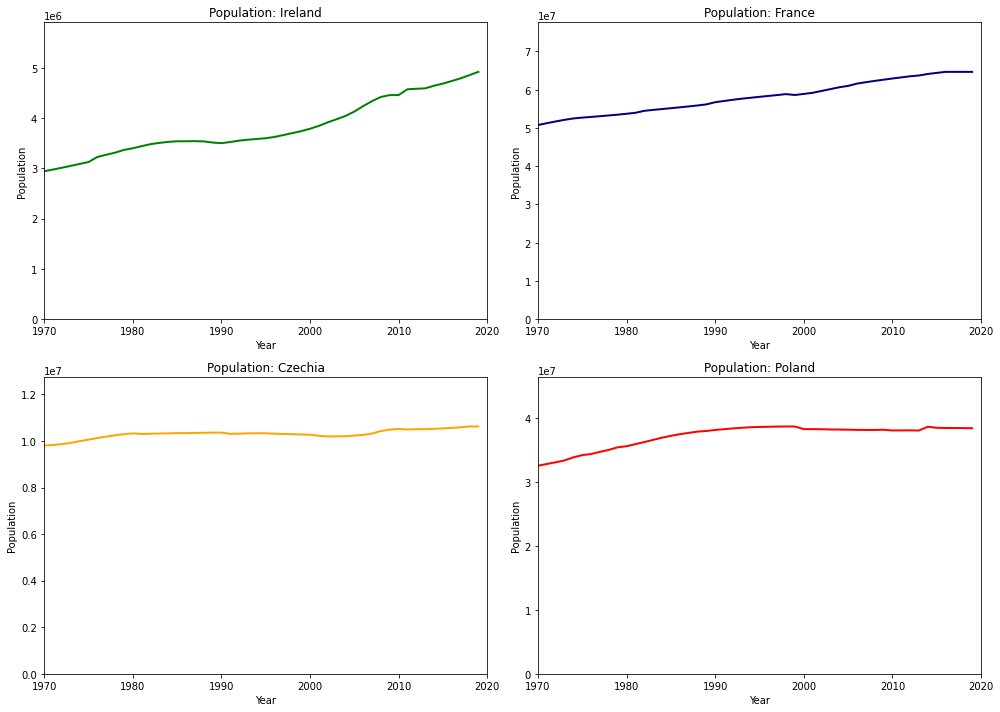

In [73]:
fig = plt.figure(figsize=(14,10))
for i, country_name in enumerate(country_names):
    axc = fig.add_subplot(2, 2, i+1)
    ax = df_countries[country_name]["Population"].plot(ax=axc, legend=False, lw=2, color = country_colours[country_name])
    ax.set_title("Population: %s" % country_name)
    ax.set_ylabel("Population")
    # note that we will use consistent Y-axis limits based on the ranges we computed above
    ax.set_ylim(0, df_pop_stats.at[country_name, "Max"]*1.2)
    ax.set_xlim(df_countries[country_name].index.min(), df_countries[country_name].index.max())
    # change the format of the dates on the x-axis
    ax.set_xlabel("Year")   
# fix the spacing between plots
fig.tight_layout()

From this graph we can see that Ireland and France have a similarly increasing while Poland had an increasing population but it stagnated around the year 2000 and declined a bit. Czechia's population was steady throughout the period

A comparison between death rates, birth rates and population in these years will give us more information on what is driving these trends in population

In [74]:
df_birth_stats = compute_stats("BirthsPer1000", df_countries)
df_birth_stats

,Min,Max,Mean,Median
Country,,,,
Ireland,13.46,22.68,17.100851,15.75
France,11.52,17.14,13.484681,13.00
Czechia,8.70,19.43,12.434255,11.72
Poland,9.19,19.71,13.846170,12.82


In [75]:
df_death_stats = compute_stats("DeathsPer1000", df_countries)
df_death_stats

,Min,Max,Mean,Median
Country,,,,
Ireland,5.93,10.43,8.155000,8.285
France,7.88,10.21,8.931364,8.710
Czechia,9.70,12.56,11.005111,11.100
Poland,7.33,9.72,8.742132,8.895


Now a comparison will be drawn between birth rate and population

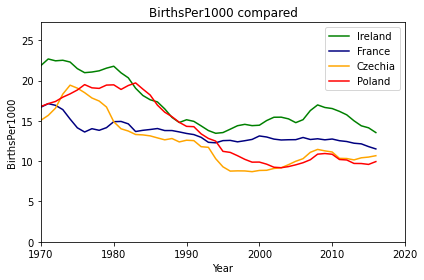

In [76]:
fig, ax1 = plt.subplots()
for i, country_name in enumerate(country_names):
    x = df_countries[country_name].index
    y = df_countries[country_name]["BirthsPer1000"]
    
    ax1.plot(x, y, color = country_colours[country_name])
    ax1.set_ylabel("BirthsPer1000")
    ax1.set_title("BirthsPer1000 compared")
   
    ax1.set_ylim(0, df_birth_stats["Max"].max()*1.2)
    ax1.set_xlim(df_countries[country_name].index.min(), df_countries[country_name].index.max())
   
    ax1.set_xlabel("Year")  
    ax1.legend(country_names)
fig.tight_layout()

Birth rates per 1000 compared on the same axes. All countries showed an overall decrease in birth rate over the period, with varying severity

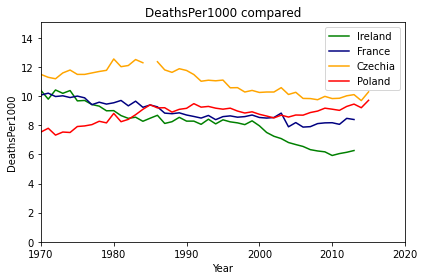

In [77]:
fig, ax1 = plt.subplots()
for i, country_name in enumerate(country_names):
    x = df_countries[country_name].index
    y = df_countries[country_name]["DeathsPer1000"]
    
    ax1.plot(x, y, color = country_colours[country_name])
    ax1.set_ylabel("DeathsPer1000")
    ax1.set_title("DeathsPer1000 compared")
    
    ax1.set_ylim(0, df_death_stats["Max"].max()*1.2)
    ax1.set_xlim(df_countries[country_name].index.min(), df_countries[country_name].index.max())
    
    ax1.set_xlabel("Year")  
    ax1.legend(country_names)
fig.tight_layout()

The death rates in France and Ireland are slowly decreasing, while in Poland it is increasing. Czechia's death rate is a bit higher than the other countries which explains the stagnant population

Now we will graph the difference between births and deaths compared to the population.

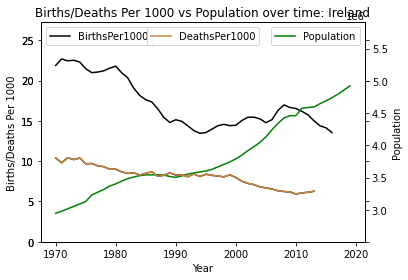

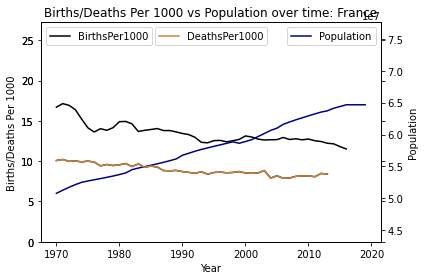

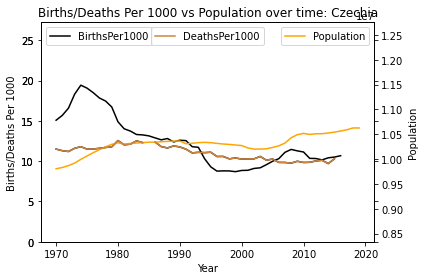

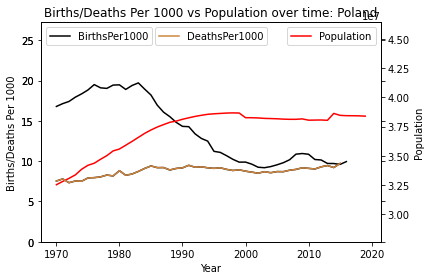

In [78]:
for i, country_name in enumerate(country_names):
    fig, ax1 = plt.subplots()
    x = df_countries[country_name].index
    y1 = df_countries[country_name]["BirthsPer1000"]
    y2 = df_countries[country_name]["Population"]
    y3 = df_countries[country_name]["DeathsPer1000"]
    
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    
    # Births
    ax1.plot(x, y1, y3, color = "black")
    # Population
    ax2.plot(x, y2, color = country_colours[country_name])
    # Deaths
    ax3.plot(x, y3, color = "peru")
    

    ax1.set_ylabel("Births/Deaths Per 1000")
    ax1.set_xlabel("Year")
    ax1.set_title("Births/Deaths Per 1000 vs Population over time: %s" % country_name)
    ax2.set_ylabel("Population")
    fig.tight_layout()

    ax1.set_ylim(0, df_birth_stats["Max"].max()*1.2)
    ax2.set_ylim(df_pop_stats.at[country_name, "Min"]*0.85, df_pop_stats.at[country_name, "Max"]*1.2)
    ax3.set_ylim(0, df_birth_stats["Max"].max()*1.2)
    
    # moving the death label to the right where it fits in behind the births label
    ax3.tick_params(labelleft=True, labelright=False)
    
    ax1.legend(["BirthsPer1000"], loc='upper left')
    ax2.legend(["Population"], loc='upper right')
    ax3.legend(["DeathsPer1000"], loc='upper center')

The birth - death rate stat should exactly dictate the trend of population assuming there is no other factors at play. Whenever the black line goes under the brown line we should see a population decrease, and other than that it should be increasing. For the most part we see that this is approximately true. Ireland and France have a steady positive birth - death rate and a steadily increasing population. When Czechia's birth - death rate dipped below 0 it saw a decrease in its population and then saw an increase again when the birth - death rate returned to being positive. Poland also generally followed this trend, except around 2000 when its population dipped even though there were slightly more people being born than dying. This cpuld be attributed to immigration for example

## Analysis of Health Expenditure and Its Effect

The health expenditure values had a high discrepancy in the null value count so we will try to ensure we are comparing like with like by removing some of the values for Ireland that arent recorded in the other countries

In [79]:
for country_name in country_names :
    print("\n" + country_name)
    print(df_countries[country_name]["HealthExpenditure"].isnull())


Ireland
Year
1970    False
1971    False
1972    False
1973    False
1974    False
1975    False
1976    False
1977    False
1978    False
1979    False
1980    False
1981    False
1982    False
1983    False
1984    False
1985    False
1986    False
1987    False
1988    False
1989    False
1990    False
1991    False
1992    False
1993    False
1994    False
1995    False
1996    False
1997    False
1998    False
1999    False
2000    False
2001    False
2002    False
2003    False
2004    False
2005    False
2006    False
2007    False
2008    False
2009    False
2010    False
2011    False
2012     True
2013     True
2014     True
2015     True
2016     True
2017     True
2018     True
2019     True
2020     True
Name: HealthExpenditure, dtype: bool

France
Year
1970    False
1971     True
1972     True
1973     True
1974     True
1975    False
1976     True
1977     True
1978     True
1979     True
1980    False
1981     True
1982     True
1983     True
1984     True
1985    Fals

Since all the other countries only start recording in 1990 we will use only Ireland's stats from 1990 onwards

In [80]:
# creating a copy of the dataframe with only the data from 1990 onwards
df_healthstats = {}
for country_name in country_names :
    df_healthstats[country_name] = df_countries[country_name][1990-1970 : 2021-1970]

df_exp_stats = compute_stats("HealthExpenditure", df_healthstats)
df_exp_stats

,Min,Max,Mean,Median
Country,,,,
Ireland,6.0,10.0,7.250000,6.90
France,8.4,11.7,10.340909,10.40
Czechia,4.4,8.0,6.468182,6.50
Poland,4.8,7.2,6.072727,6.05


In [81]:
df_expPerCapita_stats = compute_stats("HealthExpenditurePerCapita", df_healthstats)
df_expPerCapita_stats

,Min,Max,Mean,Median
Country,,,,
Ireland,785.5,4036.7,2190.309091,1911.80
France,1439.7,4117.9,2714.295455,2630.50
Czechia,527.9,2039.1,1186.422727,1030.85
Poland,288.2,1452.4,730.254545,612.60


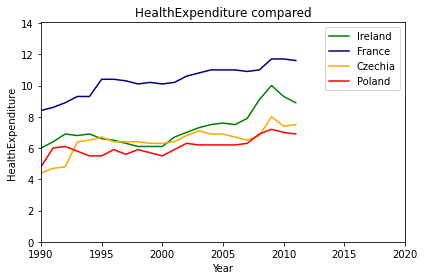

In [82]:
fig, ax1 = plt.subplots()
for i, country_name in enumerate(country_names):
    x = df_healthstats[country_name].index
    y = df_healthstats[country_name]["HealthExpenditure"]
    
    ax1.plot(x, y, color = country_colours[country_name])
    ax1.set_ylabel("HealthExpenditure")
    ax1.set_title("HealthExpenditure compared")
    # note that we will use consistent Y-axis limits based on the ranges we computed above
    ax1.set_ylim(0, df_exp_stats["Max"].max()*1.2)
    ax1.set_xlim(df_healthstats[country_name].index.min(), df_healthstats[country_name].index.max())
    # change the format of the dates on the x-axis
    ax1.set_xlabel("Year")  
    ax1.legend(country_names)
fig.tight_layout()

France's health expenditure was much higher compared to their GDP when compared to the other countries. Ireland's percentage has increased in recent years but took a sharp hit after the recession. Czechia and Poland's investment are very similar

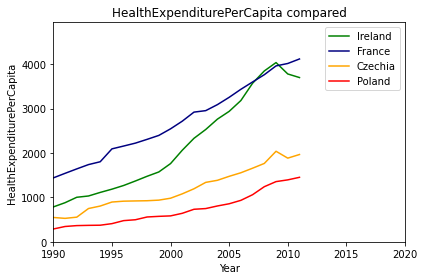

In [83]:
fig, ax1 = plt.subplots()
for i, country_name in enumerate(country_names):
    x = df_healthstats[country_name].index
    y = df_healthstats[country_name]["HealthExpenditurePerCapita"]
    
    ax1.plot(x, y, color = country_colours[country_name])
    ax1.set_ylabel("HealthExpenditurePerCapita")
    ax1.set_title("HealthExpenditurePerCapita compared")
    
    ax1.set_ylim(0, df_expPerCapita_stats["Max"].max()*1.2)
    ax1.set_xlim(df_healthstats[country_name].index.min(), df_healthstats[country_name].index.max())
    
    ax1.set_xlabel("Year")  
    ax1.legend(country_names)
fig.tight_layout()

All of the countries saw an increase in health expenditure per capita over the time ehich makes sense considering inflation. France and Ireland have the highest investment per capita followed by Czechia and then Poland

Function to merge all the stats for each country of one measure into one data frame for easy graph creation

In [84]:
def merge_data_by_column(col_name, df):
    columns = {}
    for country_name in country_names:
        columns[country_name] = df[country_name][col_name]
    df_merged = pd.DataFrame(columns).sort_index()
    
    return df_merged.dropna()

In [85]:
df_merged_exp = merge_data_by_column("HealthExpenditure", df_healthstats)
df_merged_exp

,Ireland,France,Czechia,Poland
Year,,,,
1990,6.0,8.4,4.4,4.8
1991,6.4,8.6,4.7,6.0
1992,6.9,8.9,4.8,6.1
1993,6.8,9.3,6.4,5.8
1994,6.9,9.3,6.5,5.5
1995,6.6,10.4,6.7,5.5
1996,6.5,10.4,6.4,5.9
1997,6.3,10.3,6.4,5.6
1998,6.1,10.1,6.4,5.9


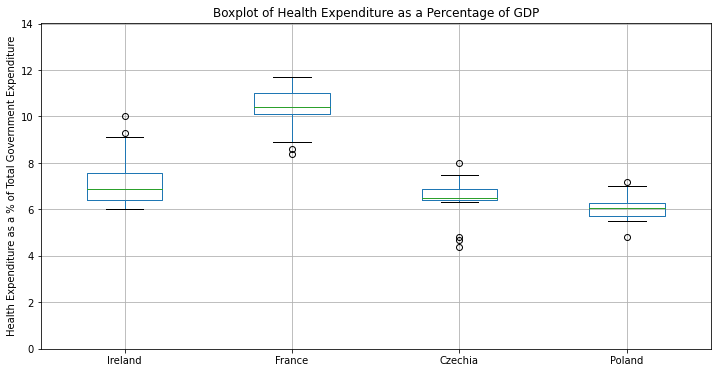

In [86]:
ax = df_merged_exp.boxplot(figsize=(12,6))
ax.set_ylim(0, df_exp_stats["Max"].max()*1.2)
ax.set_title("Boxplot of Health Expenditure as a Percentage of GDP")
ax.set_ylabel("Health Expenditure as a % of Total Government Expenditure");

This graph shows the general history of health investment and that France's general level is much higher proportion compared to the other countries, while Ireland's the highest spread. 

Now we will look at what effect these health stats might have on the hospital beds available in these countries

In [89]:
df_bed_stats = compute_stats("BedsPer100,000", df_healthstats)
df_bed_stats

,Min,Max,Mean,Median
Country,,,,
Ireland,254.98,805.06,548.327200,580.310
France,640.85,866.74,744.058333,739.295
Czechia,644.40,992.11,757.486190,764.230
Poland,642.45,668.06,658.708333,661.560


Comparing the effect of these health expenditure stats on hospital beds in these countries

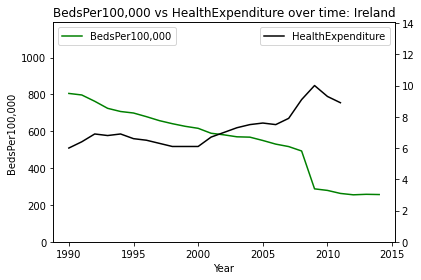

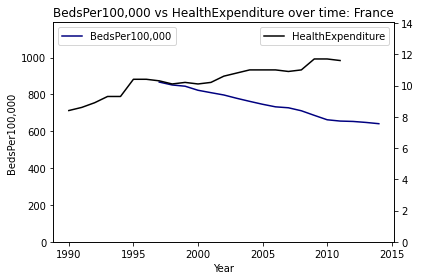

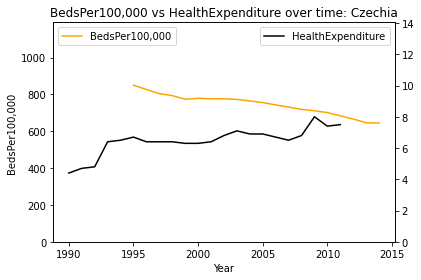

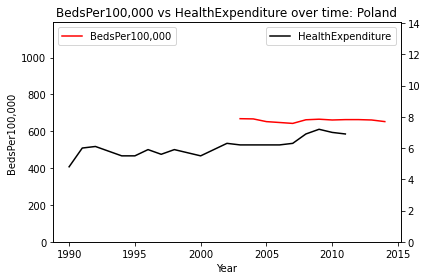

In [90]:
for i, country_name in enumerate(country_names):
    fig, ax1 = plt.subplots()
    x = df_healthstats[country_name].index
    y1 = df_healthstats[country_name]["BedsPer100,000"]
    y2 = df_healthstats[country_name]["HealthExpenditure"]

    ax2 = ax1.twinx()

    ax1.plot(x, y1, color = country_colours[country_name])
    ax2.plot(x, y2, color = "black")

    ax1.set_ylabel("BedsPer100,000")
    ax1.set_xlabel("Year")
    ax1.set_title("BedsPer100,000 vs HealthExpenditure over time: %s" % country_name)
    fig.tight_layout()
    
    ax1.set_ylim(0, df_bed_stats["Max"].max()*1.2)
    ax2.set_ylim(0, df_exp_stats["Max"].max()*1.2)
    
    ax1.legend(["BedsPer100,000"], loc='upper left')
    ax2.legend(["HealthExpenditure"], loc='upper right')

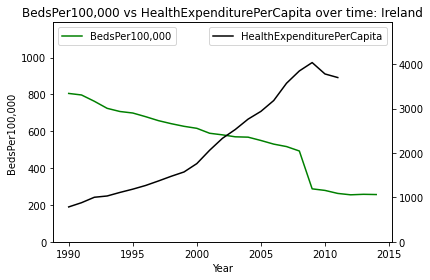

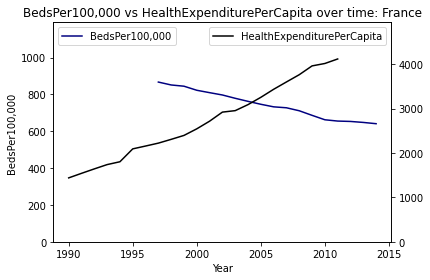

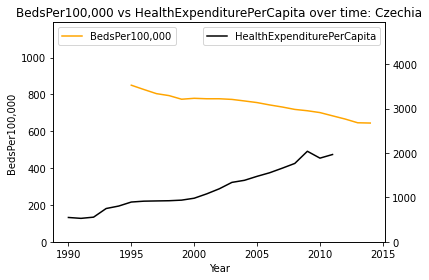

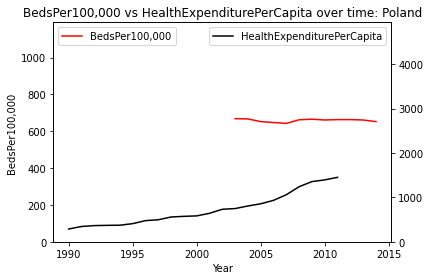

In [91]:
for i, country_name in enumerate(country_names):
    fig, ax1 = plt.subplots()
    x = df_healthstats[country_name].index
    y1 = df_healthstats[country_name]["BedsPer100,000"]
    y2 = df_healthstats[country_name]["HealthExpenditurePerCapita"]

    ax2 = ax1.twinx()

    ax1.plot(x, y1, color = country_colours[country_name])
    ax2.plot(x, y2, color = "black")

    ax1.set_ylabel("BedsPer100,000")
    ax1.set_xlabel("Year")
    ax1.set_title("BedsPer100,000 vs HealthExpenditurePerCapita over time: %s" % country_name)
    fig.tight_layout()
    
    ax1.set_ylim(0, df_bed_stats["Max"].max()*1.2)
    ax2.set_ylim(0, df_expPerCapita_stats["Max"].max()*1.2)
    
    ax1.legend(["BedsPer100,000"], loc='upper left')
    ax2.legend(["HealthExpenditurePerCapita"], loc='upper right')

There is no clear correlation between the expenditure and beds per 100,000  as most countries have a fairly steadily decreasing amount of beds regardless of their expenditure. Ireland is the exception to this going from 800 hospital beds per person to just over 200 over the time period, much lower than any other country. Ireland saw a sharp decline in beds right around the same time it took a big hit in its expenditure per capita, thanks to the recession hitting in 2008. However this does not necessarily show a correlation between the expenditure and beds. Poland's data also only started recording after 2000 and so there is not much of it to go off.

Aside from this, health expenditure per capita is not adjusted for inflation and so increases across all countries. Expressing health expenditure as a % of GDP is a better measurement for showing a trend in my opinion and I will be using that from now on in line graphs

Creating a dataframa of merged data from 2 measures, sell suited for a bar chart with 2 axes

In [92]:
rows = []
for country_name in country_names :
    row = {"Country" : country_name}
    row["HealthExpenditurePerCapita"] = df_expPerCapita_stats.at[country_name, "Mean"]
    row["BedsPer100,000"] = df_healthstats[country_name].at[2014, "BedsPer100,000"]
    rows.append(row)

df_expbedbar_stats = pd.DataFrame(rows).set_index("Country")
df_expbedbar_stats

,HealthExpenditurePerCapita,"BedsPer100,000"
Country,,
Ireland,2190.309091,256.44
France,2714.295455,640.85
Czechia,1186.422727,644.40
Poland,730.254545,652.26


Investigating Ireland's extremely low beds per 100,000

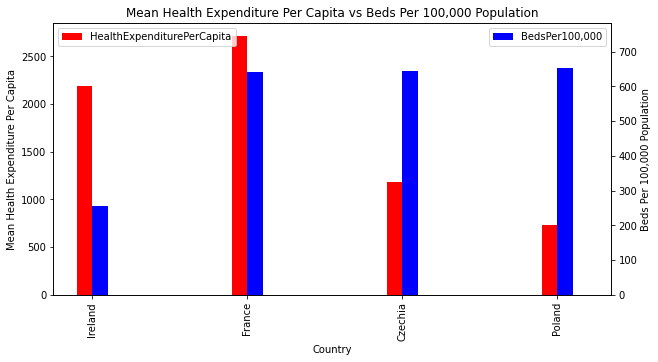

In [93]:
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.1

#input stats
df_expbedbar_stats["HealthExpenditurePerCapita"].plot(kind='bar', color='red', ax=ax, width=width, position=1)
df_expbedbar_stats["BedsPer100,000"].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

#set labels
ax.set_ylabel('Mean Health Expenditure Per Capita')
ax2.set_ylabel('Beds Per 100,000 Population')
ax.set_title("Mean Health Expenditure Per Capita vs Beds Per 100,000 Population")

ax2.set_ylim(0, df_expbedbar_stats["BedsPer100,000"].max()*1.2)
ax.legend(loc = "upper left")
ax2.legend()

plt.show()

This bar chart shows that Ireland despite having a relatively high average health expenditure, Ireland in 2014 had far less beds per 100,000 than any other one of the countries. This is one of the problems we ran into so many problems regarding pressure on our hospital service in the coronavirus pandemic.

Comparing health expenditure stats to life expectancy

In [94]:
df_lifeexpectancy_stats = compute_stats("LifeExpectancy", df_countries)
df_lifeexpectancy_stats

,Min,Max,Mean,Median
Country,,,,
Ireland,76.41196,81.53663,79.588733,79.92730
France,79.11186,82.94602,81.029753,81.09863
Czechia,75.00063,79.16503,77.112521,77.28784
Poland,73.73580,77.75282,75.805745,75.59730


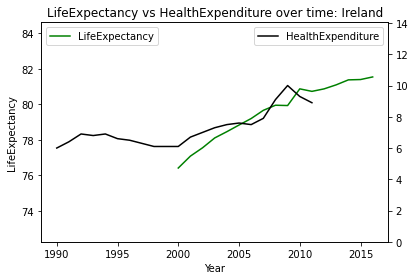

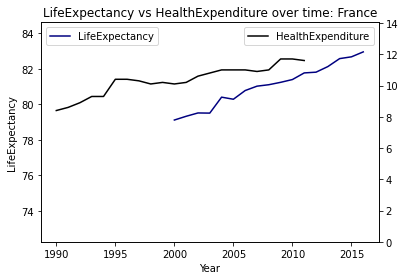

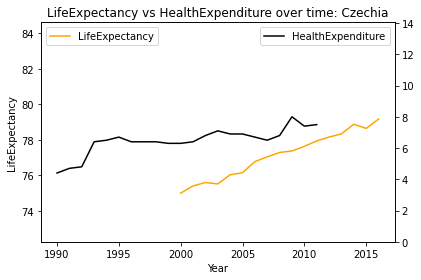

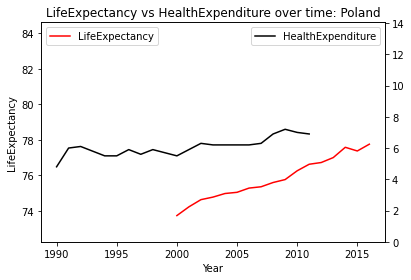

In [95]:
for i, country_name in enumerate(country_names):
    fig, ax1 = plt.subplots()
    x = df_healthstats[country_name].index
    y1 = df_healthstats[country_name]["LifeExpectancy"]
    y2 = df_healthstats[country_name]["HealthExpenditure"]

    ax2 = ax1.twinx()

    ax1.plot(x, y1, color = country_colours[country_name])
    ax2.plot(x, y2, color = "black")

    ax1.set_ylabel("LifeExpectancy")
    ax1.set_xlabel("Year")
    ax1.set_title("LifeExpectancy vs HealthExpenditure over time: %s" % country_name)
    fig.tight_layout()
    
    ax1.set_ylim(df_lifeexpectancy_stats["Min"].min()*.98, df_lifeexpectancy_stats["Max"].max()*1.02)
    ax2.set_ylim(0, df_exp_stats["Max"].max()*1.2)
    
    ax1.legend(["LifeExpectancy"], loc='upper left')
    ax2.legend(["HealthExpenditure"], loc='upper right')

The highest investing countries in Ireland and France have a higher life expectancy than the lower investing countries. However it is hard to see exactly how high this correlation is

In [96]:
rows = []
for country_name in country_names :
    row = {"Country" : country_name}
    row["HealthExpenditurePerCapita"] = df_expPerCapita_stats.at[country_name, "Mean"]
    row["LifeExpectancy"] = df_lifeexpectancy_stats.at[country_name, "Mean"]
    rows.append(row)

df_expLEbar_stats = pd.DataFrame(rows).set_index("Country")
df_expLEbar_stats

,HealthExpenditurePerCapita,LifeExpectancy
Country,,
Ireland,2190.309091,79.588733
France,2714.295455,81.029753
Czechia,1186.422727,77.112521
Poland,730.254545,75.805745


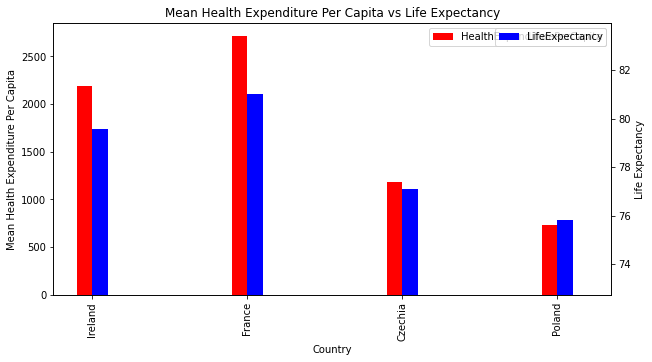

In [97]:
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.1

df_expLEbar_stats["HealthExpenditurePerCapita"].plot(kind='bar', color='red', ax=ax, width=width, position=1)
df_expLEbar_stats["LifeExpectancy"].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Mean Health Expenditure Per Capita')
ax2.set_ylabel('Life Expectancy')
ax.set_title("Mean Health Expenditure Per Capita vs Life Expectancy")
ax.legend()
ax2.legend()

ax2.set_ylim(df_lifeexpectancy_stats["Min"].min()-1, df_lifeexpectancy_stats["Max"].max()+1)

plt.show()

We can see from this chart that the countries with higher health investment per capita have a higher life expectancy. However it is not certain that investing heavier in health increases life expectancy. For example, it is more likely that countries who can afford to invest more heavily in health are also safer places to live.

 ## Correlation between countries
 
 Checking the extent that the countries stats correlate with each other
 
 Define a function to compute the pairwise Pearson correlations between the countries and displays this as a 'heatmap' visualisation:

In [98]:
def plot_heatmap(title, df_in, figsize=(5.5, 5)):
    df_corr = df_in.corr()
    # create a color palettte
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_corr, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title(title)

In [99]:
df_merged_pop = merge_data_by_column("Population", df_countries)

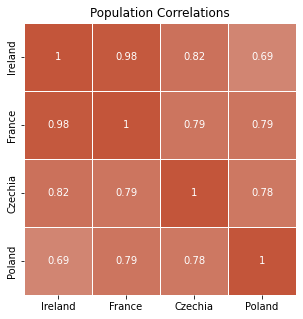

In [100]:
plot_heatmap("Population Correlations", df_merged_pop)

The population trends are all heavily correlated, especially the trends of Ireland and France. Poland has the lowest correlation with the rest

In [101]:
df_merged_birth = merge_data_by_column("BirthsPer1000", df_countries)

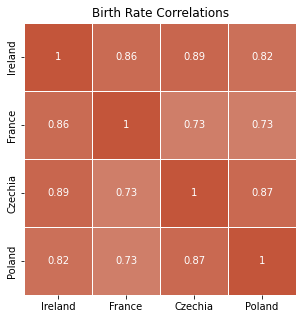

In [102]:
plot_heatmap("Birth Rate Correlations", df_merged_birth)

The birth rates also had a very high correlation with each countries decreasing as time went on

In [103]:
df_merged_death = merge_data_by_column("DeathsPer1000", df_countries)

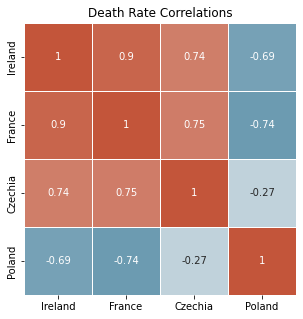

In [104]:
plot_heatmap("Death Rate Correlations", df_merged_death)

The correlation is high here between Ireland, France and Czechia but Poland, being the only country that saw an increase in death rates has a negative correlation with the other countries. This might explain why Poland has the lowest correlation in population stats

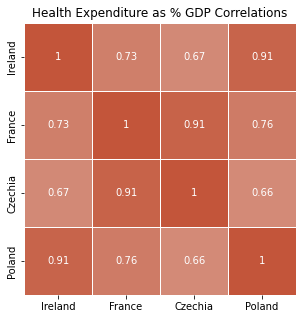

In [105]:
plot_heatmap("Health Expenditure as % GDP Correlations", df_merged_exp)

There is a reasonable correlation between all of the countries with Ireland to Poland and France to Czechia being the most correlated. All of the countries have somewhat increased their investment in health compared to their GDP in the time period

In [106]:
df_merged_le = merge_data_by_column("LifeExpectancy", df_countries)

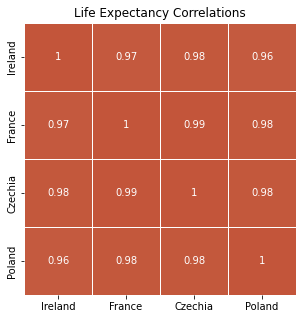

In [107]:
plot_heatmap("Life Expectancy Correlations", df_merged_le)

We see here that all the countries have almost perfectly correlated life expectancy trends despite their difference in health expenditure. This shows that life expectancy naturally trends upwards very similarly in all these countries regardless of their investment in health

# Conclusion

In this assignment we looked at the health data from four different countries and tried to find some similarites and patterns between the data, looking at how one stat might correlate or change with the others. We found that birth rates and death rates have an obvious effect on population which is to be expected if this data is to be trusted. 

We also found that the amount invested into health has no obvious direct effect on the amount of hospital beds in a country, however it has some possible relation to life expectancy. The countries with higher life expectancy had a much higher investment in the health service per capita. However this may not be a direct effect. 

Finally we found that Ireland somehow has far less hospital beds available per capita than any of the other countries which is why our health service struggled with the pandemic

This API was useful but not perfect. I had to cut the health expenditure data to only 1990 onwards as most of the countries did not have this data. Some countries I had previously picked for this analysis such as Croatia did not have any of the data I required which lead me to changing countries multiple times. The data also required a lot of processing to be useable.

If this project were to be continued, it could be applied to more countries in the WHO database, and also to a lot more measures that are available in the database